In [1]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
sys.path.insert(0,"../")
from castle import train_ensamble_linear_model, train_linear_model, ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils

%load_ext autoreload
%autoreload 2

In [22]:
est to fulfill your requests the situation with the Covid-19 pandemic has
meant that we have not always been able torcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1}
root = "/home/claudio/postdoc/data/Zuo/"

species = 'Ni'
N = 5
maxdeg = 6
rcut = rcuts[species]

tr_features, val_features = utils.extract_local_features(root + f"{species}/", "train_trajectory.xyz", "validation_trajectory.xyz",
                                             N=N, maxdeg=maxdeg, rcut=rcut, force_name = 'force', energy_name = 'energy',
                                            species = species)
np.save(root + f"{species}/" + f"tr_local_features_N_{N}_d_{maxdeg}.npy", np.concatenate(tr_features.X))
np.save(root + f"{species}/" + f"val_local_features_N_{N}_d_{maxdeg}.npy", np.concatenate(val_features.X))
print(np.concatenate(tr_features.X).shape)

(27420, 31)


In [84]:
folder = "/home/claudio/postdoc/data/Au_13/"


species = 'Au'
N = 5
maxdeg = 8
rcut = 5.0
temp = 400

tr_features = utils.extract_local_features(folder,  f"planar_{temp}K.xyz",
                                             N=N, maxdeg=maxdeg, rcut=rcut, force_name = 'force', energy_name = 'energy',
                                            species = species)
np.save(folder + f"planar_{temp}K_local_features_N_{N}_d_{maxdeg}.npy", np.concatenate(tr_features.X))
print(np.concatenate(tr_features.X).shape)

(13000, 77)


MAE=0.007 RMSE=0.009 SUP=0.073 R2=0.632
MAE=0.219 RMSE=0.313 SUP=4.263 R2=0.839


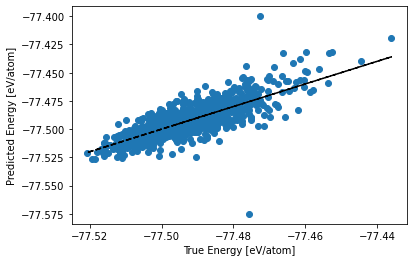

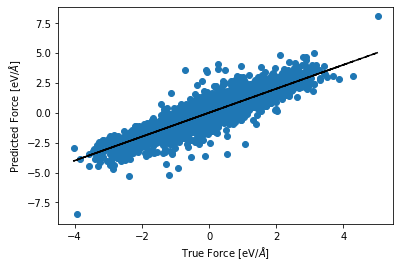

In [29]:
noise = 1e-8
model = train_linear_model(tr_features, noise, e_t, f_t)

# evaluate its performances
ep = model.predict_energy(tr_features)
fp = model.predict_forces(tr_features)

print_score(ep/nat_tr, e_t/nat_tr)
print_score(fp.flatten(), f_t.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_t/nat_tr, ep/nat_tr)
plt.plot(e_t/nat_tr, e_t/nat_tr, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_t, fp)
plt.plot(f_t, f_t, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

MAE=0.003 RMSE=0.004 SUP=0.008 R2=0.274
MAE=0.139 RMSE=0.182 SUP=1.030 R2=0.799


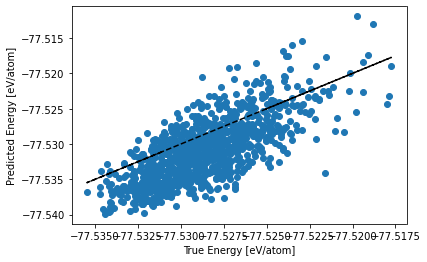

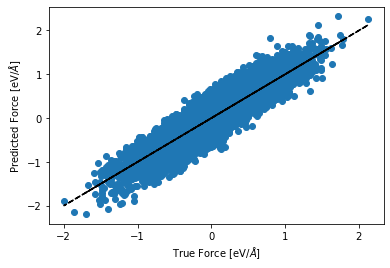

In [30]:
noise = 1e-8
model = train_linear_model(tr_features, noise, e_t, f_t)

# evaluate its performances
ep = model.predict_energy(val_features)
fp = model.predict_forces(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

In [2]:
rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1}
root = "/home/claudio/postdoc/data/Zuo/"

species = 'Ni'
N = 5
maxdeg = 10
rcut = rcuts[species]

tr_features, val_features = utils.extract_features(root + f"{species}/", "train_trajectory.xyz", "validation_trajectory.xyz",
                                             N=N, maxdeg=maxdeg, rcut=rcut, force_name = 'force', energy_name = 'energy',
                                            species = species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root + f"{species}/",
    "train_trajectory.xyz", "validation_trajectory.xyz", 
    f"tr_features_N_{N}_d_{maxdeg}.xz", f"val_features_N_{N}_d_{maxdeg}.xz")

MAE=0.001 RMSE=0.002 SUP=0.002 R2=1.000
MAE=0.052 RMSE=0.138 SUP=4.349 R2=0.979


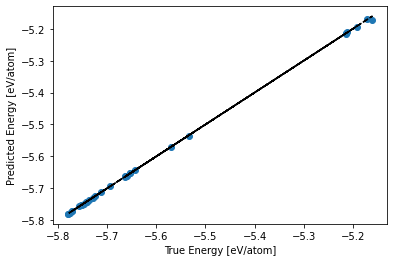

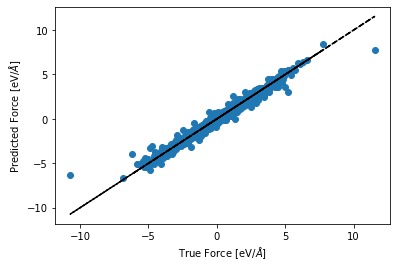

In [3]:
noise = 1e-8
model = train_linear_model(tr_features, noise, e_t)

# evaluate its performances
ep = model.predict_energy(val_features)
fp = model.predict_forces(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

Using 9 clusters
MAE=0.001 RMSE=0.001 SUP=0.002 R2=1.000
MAE=0.021 RMSE=0.043 SUP=0.408 R2=0.998


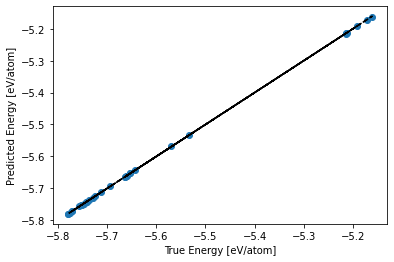

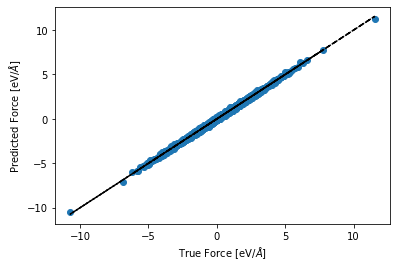

In [4]:
noise = 1e-8
n_clusters = 'auto'
n_neighbours = 1
# train the model
model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=n_neighbours, 
                         n_clusters=n_clusters, clustering='e_gmm')

# evaluate its performances
ep = model.predict_energy(val_features)
fp = model.predict_forces(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

Using 9 clusters
MAE=0.001 RMSE=0.001 SUP=0.002 R2=1.000
MAE=0.021 RMSE=0.043 SUP=0.408 R2=0.998


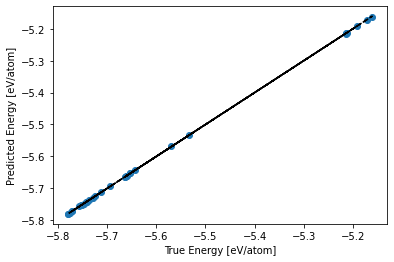

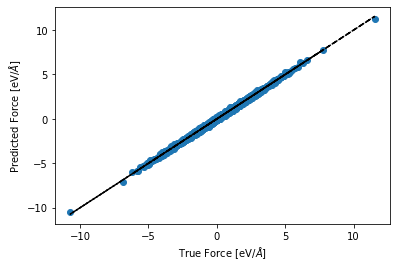

In [29]:
noise = 1e-8
n_clusters = 'auto'
n_neighbours = 1
# train the model
model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=n_neighbours, 
                         n_clusters=n_clusters, clustering='e_gmm')

# evaluate its performances
ep = model.predict_energy(val_features)
fp = model.predict_forces(val_features)
# vp = model.predict_stress(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())
# print_score(vp.flatten(), s_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

In [43]:
noise = 1e-8
model_lin = train_linear_model(tr_features, noise, e_t)

model_ens_1 =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=1, 
                         n_clusters='auto', clustering='e_gmm')

model_ens_10 =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=10, 
                         n_clusters='auto', clustering='e_gmm')

Using 9 clusters
Using 9 clusters


In [56]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

model_ens_10 =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                        n_neighbours=10, 
                         n_clusters='auto', clustering='e_gmm')

atoms = Atoms(read(root + f"{species}/" + "validation_trajectory.xyz", index = 0))
calc = ASEMLCalculator(model_ens_10, model.representation)
atoms.set_calculator(calc)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 5 * units.fs)  # 5 fs time step.

def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Using 9 clusters
Energy per atom: Epot = -5.653eV  Ekin = 0.037eV (T=289K)  Etot = -5.615eV
Energy per atom: Epot = -5.706eV  Ekin = 0.090eV (T=694K)  Etot = -5.616eV
Energy per atom: Epot = -5.679eV  Ekin = 0.064eV (T=493K)  Etot = -5.616eV
Energy per atom: Epot = -5.698eV  Ekin = 0.082eV (T=631K)  Etot = -5.616eV
Energy per atom: Epot = -5.693eV  Ekin = 0.077eV (T=593K)  Etot = -5.616eV
Energy per atom: Epot = -5.698eV  Ekin = 0.082eV (T=632K)  Etot = -5.616eV
Energy per atom: Epot = -5.682eV  Ekin = 0.066eV (T=509K)  Etot = -5.616eV
Energy per atom: Epot = -5.691eV  Ekin = 0.075eV (T=582K)  Etot = -5.616eV
Energy per atom: Epot = -5.685eV  Ekin = 0.069eV (T=535K)  Etot = -5.616eV
Energy per atom: Epot = -5.690eV  Ekin = 0.074eV (T=575K)  Etot = -5.616eV
Energy per atom: Epot = -5.691eV  Ekin = 0.075eV (T=580K)  Etot = -5.616eV
Energy per atom: Epot = -5.686eV  Ekin = 0.070eV (T=540K)  Etot = -5.616eV
Energy per atom: Epot = -5.693eV  Ekin = 0.077eV (T=595K)  Etot = -5.616eV
Energy p